In [6]:
# %load ./init.ipy
%reload_ext autoreload
%autoreload 2
from importlib import reload

# import os
# import sys
# import logging
import warnings
import numpy as np
# import astropy as ap
# import scipy as sp
# import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt

# import h5py
import tqdm.notebook as tqdm

import kalepy as kale
# import kalepy.utils
# import kalepy.plot

import holodeck as holo
# import holodeck.gravwaves
from holodeck import cosmo, utils, plot
from holodeck.constants import MSOL, PC, YR, GYR

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
plt.rcParams.update({'grid.alpha': 0.5})
mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode

log = holo.log

In [2]:
resamp = holo.population.PM_Resample(0.5)    # downsample for faster execution
ecc = holo.population.PM_Eccentricity()
pop = holo.population.Pop_Illustris(mods=[ecc, resamp])

# `Fixed_Time` phenomenological hardening model

In [3]:
Fixed_Time = holo.hardening.Fixed_Time

## Basic Example

Choose a set time interval over which binaries should coalesce, and evolve the population

In [4]:
time = 6.0 * GYR
fixed = holo.hardening.Fixed_Time.from_pop(pop, time, gamma_sc=-0.5, gamma_df=+1.5)
evo = holo.evolution.Evolution(pop, fixed)
evo.evolve()

14:52:29 WARNING : class `Fixed_Time` has been deprecated!  Please use `Fixed_Time_2PL` with new parametrization! [hardening.py:__init__]
14:52:29 INFO : calculating normalization exactly [hardening.py:__init__]


Plot the distribution of actual lifetimes, which will differ slightly due to the approximations being used.

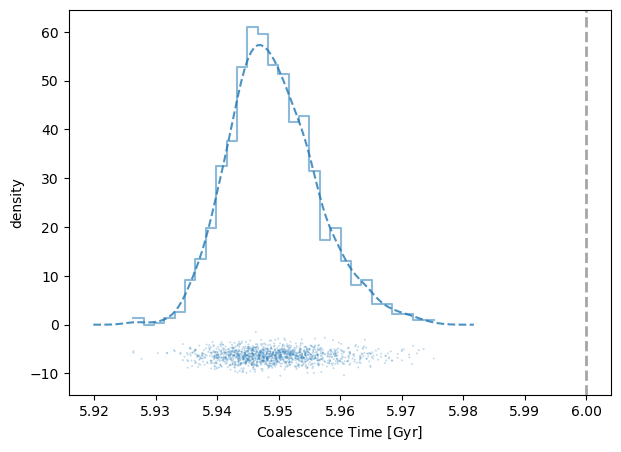

In [7]:
tage = evo.tage   #: Age of the universe for each binary and time-step, shaped (B, T)
dt = tage[:, -1] - tage[:, 0]   #: Difference in time from start to end, for each binary

fig, ax = plot.figax(scale='lin', xlabel='Coalescence Time $[\mathrm{Gyr}]$', ylabel='density')
# plot distribution using `kalepy`
kale.dist1d(dt/GYR, density=True)
ax.axvline(time/GYR, ls='--', color='k', alpha=0.35, lw=2.0)
plt.show()

## Plot evolutionary tracks (hardening timescale vs separation)

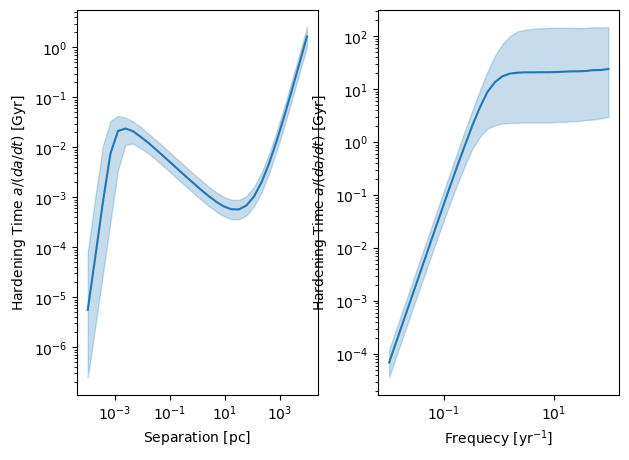

In [8]:
NUM = 30
xname = ['sepa', 'fobs']
xvals = [np.logspace(-4, 4, NUM), np.logspace(-2, 2, NUM)] 
units = [PC, 1/YR]

fig, axes = plot.figax(
    ncols=2, wspace=0.25,
    ylabel='Hardening Time $a/\\left(da/dt\\right)$ $[\mathrm{Gyr}]$',
    xlabel=['Separation $[\mathrm{pc}]$', 'Frequecy $[\mathrm{yr}^{-1}]$'],                    
)

for ax, nn, xx, uu in zip(axes, xname, xvals, units):
    data = evo.at(nn, xx*uu, params='dadt', lin_interp=True)
    tt = xvals[0] / -(data['dadt']*GYR/PC)

    # med, *conf = np.percentile(tt, [50, 25, 75], axis=0)
    med, *conf = utils.quantile_filtered(tt, percs=[0.5, 0.25, 0.75], axis=0)
    hh, = ax.plot(xx, med)
    ax.fill_between(xx, *conf, alpha=0.25, color=hh.get_color())
    
plt.show()

## Functional Form of the hardening model

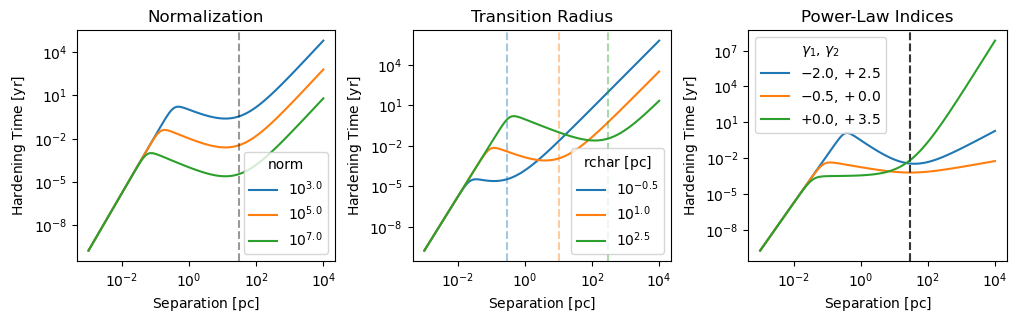

In [9]:
rads = np.logspace(-3, 4, 100)
mtot = 1.0e9 * MSOL
mrat = 0.2
rchar = 30.0 * PC
g1 = -1.0
g2 = +2.5
norm = 1e5

fig, axes = plot.figax(
    figsize=[12, 3], ncols=3, wspace=0.3, 
    xlabel='Separation $[\mathrm{pc}]$', ylabel='Hardening Time $[\mathrm{yr}]$',
)

kw_vline = dict(alpha=0.4, ls='--')

# ---- Vary the normalization
ax = axes[0]
ax.set(title="Normalization")
for nn in [1e3, 1e5, 1e7]:
    yy, _ = Fixed_Time._dadt_dedt(mtot, mrat, rads*PC, nn, rchar, g1, g2)
    yy = np.fabs(yy)
    yy = rads / yy
    ax.plot(rads, yy, label=f"$10^{{{np.log10(nn):.1f}}}$")

ax.axvline(rchar/PC, color='k', **kw_vline)
ax.legend(title='norm')

# ---- Vary the transition radius
ax = axes[1]
ax.set(title="Transition Radius")
for rc in [3e-1, 1e1, 3e2]:
    yy, _ = Fixed_Time._dadt_dedt(mtot, mrat, rads*PC, norm, rc*PC, g1, g2)
    yy = np.fabs(yy)
    yy = rads / yy
    lab = f"$10^{{{np.log10(rc):.1f}}}$"
    hh, = ax.plot(rads, yy, label=lab)
    ax.axvline(rc, color=hh.get_color(), **kw_vline)
    
ax.legend(title='rchar $[\mathrm{pc}]$')

# ---- Vary power-law indices
ax = axes[2]
ax.set(title="Power-Law Indices")
for gg in [[-2.0, 2.5], [-0.5, 0.0], [+0.0, 3.5]]:
    yy, _ = Fixed_Time._dadt_dedt(mtot, mrat, rads*PC, norm, rchar, *gg)
    yy = np.fabs(yy)
    yy = rads / yy
    lab = "${:+.1f}, {:+.1f}$".format(*gg)
    ax.plot(rads, yy, label=lab)
    ax.axvline(rchar/PC, color='k', **kw_vline)
    
ax.legend(title='$\gamma_1$, $\gamma_2$')


plt.show()

# Physical Processes

## Dynamical Friction

In [10]:
df = holo.hardening.Dynamical_Friction_NFW()

14:53:12 INFO : clipping 2.70e+01/1.00e+02 = 2.70e-01 `dadt` values to vcirc [hardening.py:_dadt_dedt]
14:53:12 INFO : clipping 3.10e+01/1.00e+02 = 3.10e-01 `dadt` values to vcirc [hardening.py:_dadt_dedt]


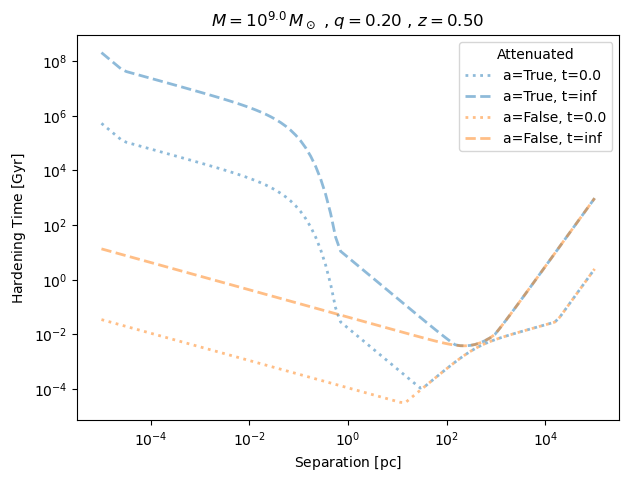

In [12]:
mtot = 1e9*MSOL
mrat = 0.2
redz = 0.5
sepa = np.logspace(-5, 5, 100)
m1m2 = utils.m1m2_from_mtmr(mtot, mrat)

def plot_df_dadt(m1m2, sepa, redz, times, eccen, atten, **kwargs):
    dadt_df, _ = df._dadt_dedt(m1m2, sepa, redz, times, eccen, atten)
    tau = sepa / -dadt_df
    tau /= GYR
    return ax.plot(sepa/PC, tau, **kwargs)


fig, ax = plot.figax(xlabel='Separation $[\mathrm{pc}]$', ylabel='Hardening Time $[\mathrm{Gyr}]$')
title = [
    rf"M = 10^{{{np.log10(mtot/MSOL):.1f}}} \, M_\odot",
    # rf"q = 10^{{{np.log10(mrat):.1f}}}",
    rf"q = {mrat:.2f}",
    rf"z = {redz:.2f}",
]
title = ['$' + tt + '$' for tt in title]
title = " , ".join(title)

ax.set_title(title, fontsize=12)
colors = [ax._get_lines.get_next_color() for ii in range(2)]
lines = [':', '--']

for ii, atten in enumerate([True, False]):
    for jj, time in enumerate([0.0, np.inf]):
        lab = f'a={atten}, t={time}'
        col = colors[ii]
        ls = lines[jj]
        kw = dict(color=col, ls=ls, label=lab, alpha=0.5, lw=2.0)
        plot_df_dadt(m1m2, sepa*PC, redz, time, eccen=0.0, atten=atten, **kw)

ax.legend(title='Attenuated')
plt.show()


# Composite Hardening Model

In [13]:
hards = [
    holo.hardening.Hard_GW,
    holo.hardening.Sesana_Scattering(),
    holo.hardening.Dynamical_Friction_NFW(),
]

Construct `Evolution` instance and run

In [14]:
evo = holo.evolution.Evolution(pop, hards, debug=True)
evo.evolve()

14:53:38 INFO : clipping 6.50e+01/1.37e+03 = 4.73e-02 `dadt` values to vcirc [hardening.py:_dadt_dedt]
14:53:38 INFO : clipping 6.50e+01/1.37e+03 = 4.73e-02 `dadt` values to vcirc [hardening.py:_dadt_dedt]
14:53:38 INFO : clipping 8.90e+01/1.37e+03 = 6.48e-02 `dadt` values to vcirc [hardening.py:_dadt_dedt]
14:53:38 INFO : clipping 9.00e+01/1.37e+03 = 6.55e-02 `dadt` values to vcirc [hardening.py:_dadt_dedt]
14:53:38 INFO : clipping 9.90e+01/1.37e+03 = 7.21e-02 `dadt` values to vcirc [hardening.py:_dadt_dedt]
14:53:38 INFO : clipping 9.90e+01/1.37e+03 = 7.21e-02 `dadt` values to vcirc [hardening.py:_dadt_dedt]
14:53:38 INFO : clipping 1.07e+02/1.37e+03 = 7.79e-02 `dadt` values to vcirc [hardening.py:_dadt_dedt]
14:53:38 INFO : clipping 1.08e+02/1.37e+03 = 7.86e-02 `dadt` values to vcirc [hardening.py:_dadt_dedt]
14:53:38 INFO : clipping 1.19e+02/1.37e+03 = 8.66e-02 `dadt` values to vcirc [hardening.py:_dadt_dedt]
14:53:38 INFO : clipping 1.19e+02/1.37e+03 = 8.66e-02 `dadt` values to vc

Interpolate evolutionary tracks to regular intervals for plotting

In [15]:
rads = np.logspace(-4, 4, 100) * PC
num_hard = len(hards)
params = ['eccen', 'dadt', 'dedt',]
params += [f'_dadt_{ii}' for ii in range(num_hard)]
params += [f'_dedt_{ii}' for ii in range(num_hard)]

# lin_interp_list = evo._LIN_INTERP_PARS + params
lin_interp_list = params
data = evo.at('sepa', rads, params=params, lin_interp=lin_interp_list)

Plot evolutionary tracks

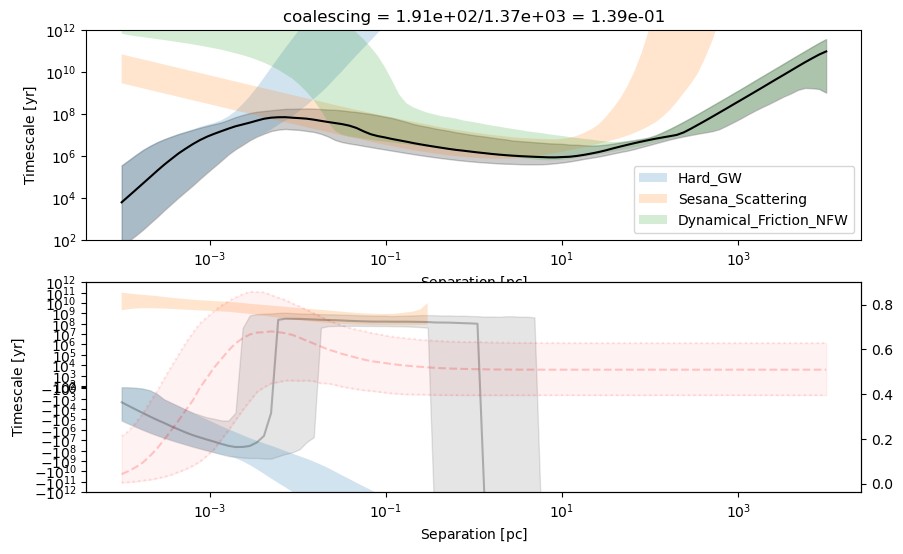

In [16]:
fig, axes = plot.figax(
    figsize=[10, 6], nrows=2,
    xlabel=r"Separation $[\mathrm{pc}]$", ylabel=r'Timescale $[\mathrm{yr}]$',
)


frac = utils.frac_str(evo.scafa[:, -1] < 1.0, )
xx = rads / PC

ax = axes[0]
ax.set(title=f"coalescing = {frac}", ylim=[1e2, 1e12])
dadt = data['dadt']
vals = np.fabs(dadt)
vals = rads / vals
vals = vals / YR
confs = utils.quantiles(vals, sigmas=[-1, 0, 1], axis=0)
confs = confs.T
med, *confs = confs[[1, 0, 2]]

ax.plot(xx, med, 'k-')
ax.fill_between(xx, *confs, color='k', alpha=0.2)

ax = axes[1]
ax.set_yscale('symlog', linthresh=1e3)
ax.set(ylim=[-1e12, 1e12])
vals = data["dedt"]
vals = data['eccen'] / vals
vals = vals / YR
confs = utils.quantiles(vals, sigmas=[-1, 0, 1], axis=0)
confs = confs.T
med, *confs = confs[[1, 0, 2]]
ax.plot(xx, med, 'k-', alpha=0.25)
ax.fill_between(xx, *confs, color='k', alpha=0.1)

vals = data['eccen']
xx = rads / PC
confs = utils.quantiles(vals, sigmas=[-1, 0, 1], axis=0)
confs = confs.T
med, *confs = confs[[1, 0, 2]]

tw = ax.twinx()
tw.set(yscale='linear', label='eccentricity')
col = 'r'
tw.plot(xx, med, ls='--', color=col, alpha=0.2)
tw.plot(xx, confs[0], ls=':', color=col, alpha=0.1)
tw.plot(xx, confs[-1], ls=':', color=col, alpha=0.1)
tw.fill_between(xx, *confs, color=col, alpha=0.05)

for ii in range(num_hard):
    try:
        lab = hards[ii].__name__
    except AttributeError:
        lab = hards[ii].__class__.__name__
        
    vals = np.fabs(data[f"_dadt_{ii}"])
    vals = rads / vals
    vals = vals / YR

    confs = utils.quantiles(vals, sigmas=[-1, 1], axis=0).T
    axes[0].fill_between(xx, *confs, alpha=0.2, label=lab)

    # eccentricity
    if evo.eccen is None:
        continue

    vals = data[f"_dedt_{ii}"]
    vals = data['eccen'] / vals
    vals = vals / YR

    confs = utils.quantiles(vals, sigmas=[-1, 1], axis=0).T
    axes[1].fill_between(xx, *confs, alpha=0.2)

axes[0].legend(loc='lower right')
plt.show()